In [42]:
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
import daft
from scipy import stats
from theano import shared

In [3]:
data_path = '/home/jonathan/Projects/LearningReferences/statrethink_course_in_pymc3/data/foxes.csv'
fox_df = pd.read_csv(data_path, sep=';', header=0)

In [35]:
def standardize(series):
    std_series = (series - series.mean()) / series.std()
    return std_series

In [37]:
fox_df['groupsize_std'] = standardize(fox_df.groupsize)
fox_df['avgfood_std'] = standardize(fox_df.avgfood)
fox_df['area_std'] = standardize(fox_df.area)
fox_df['weight_std'] = standardize(fox_df.weight)

In [38]:
fox_df.head(2)

,group,avgfood,groupsize,area,weight,groupsize_std,avgfood_std,area_std,weight_std
0,1,0.37,2,1.09,5.02,-1.524089,-1.924829,-2.239596,0.414135
1,1,0.37,2,1.09,2.84,-1.524089,-1.924829,-2.239596,-1.427046


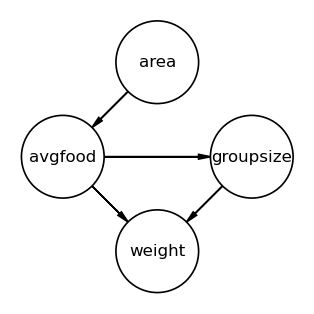

In [30]:
dag = CausalGraphicalModel(nodes=['area', 'avgfood', 'groupsize', 'weight'], 
                           edges=[('area', 'avgfood'), ('avgfood', 'groupsize'), ('avgfood', 'weight'), ('groupsize', 'weight')])

coordinates = {'area': (1, 0), 'avgfood': (0, 1), 'groupsize': (2, 1), 'weight': (1, 2)}
pgm = daft.PGM(dpi=120)

for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node], scale=1.75)
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [31]:
dag.get_all_independence_relationships()

[('area', 'groupsize', {'avgfood'}),
 ('area', 'groupsize', {'avgfood', 'weight'}),
 ('area', 'weight', {'avgfood'}),
 ('area', 'weight', {'avgfood', 'groupsize'})]

In [34]:
dag.get_all_backdoor_adjustment_sets("area", "weight")

frozenset({frozenset()})

In [185]:
dag.get_all_backdoor_adjustment_sets("avgfood", "weight")

frozenset({frozenset(), frozenset({'area'})})

In [186]:
dag.get_all_backdoor_adjustment_sets("groupsize", "weight")

frozenset({frozenset({'avgfood'}), frozenset({'area', 'avgfood'})})

1. **Use a model to infer the total causal influence of area on weight . Would
increasing the area available to each fox make it heavier (healthier)? You
might want to standardize the variables. Regardless, use prior predictive
simulation to show that your model’s prior predictions stay within the possible outcome range.**

In [196]:
area_std_shrd = shared(fox_df.area_std.values)

with pm.Model() as hw1:
    area = pm.Normal('area', 0, .3)
    alpha = pm.Normal('alpha', 0, .2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + area*area_std_shrd)
    weight = pm.Normal('weight', mu, sigma, observed=fox_df.weight_std)
    hw1_prior_pred = pm.sample_prior_predictive(var_names=['area', 'weight', 'alpha'])
    hw1_trace = pm.sample()
    hw1_posterior_sample = pm.sample_posterior_predictive(hw1_trace)
    data1 = az.from_pymc3(trace=hw1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, area]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [146]:
# Posterior influence
with hw1:
    display(az.summary(hw1_trace, hdi_prob=.89, skipna=True, kind='stats', var_names=['area', 'alpha', 'sigma']).round(2))

,mean,sd,hdi_5.5%,hdi_94.5%
area,0.02,0.09,-0.14,0.15
alpha,-0.00,0.09,-0.14,0.14
sigma,1.01,0.07,0.91,1.12


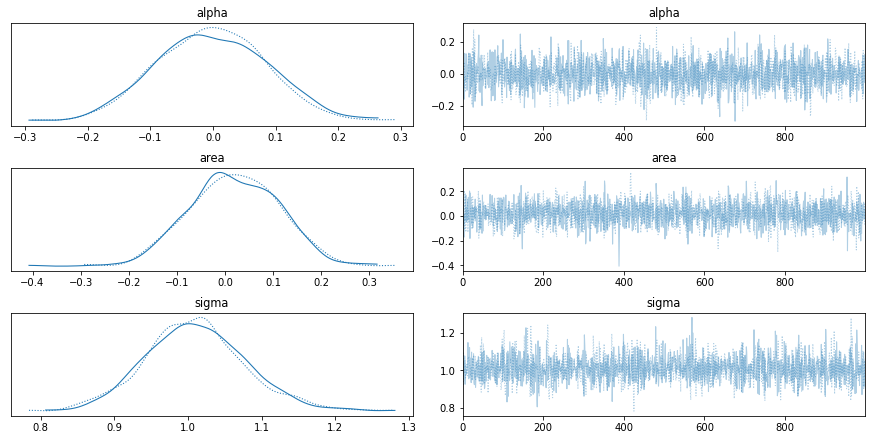

In [151]:
with hw1:
    pm.traceplot(hw1_trace, var_names=['alpha', 'area', 'sigma'])

In [168]:
hw1_posterior_sample['weight'].mean(axis=0)[:10]

array([-0.04375876, -0.06110431,  0.03704741, -0.01156078, -0.00940936,
       -0.03184294, -0.07519381, -0.0377745 ,  0.0328403 , -0.00912205])

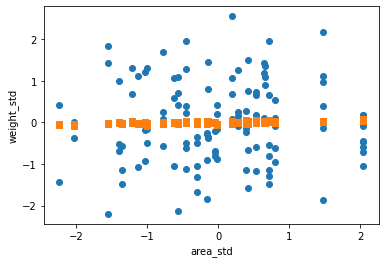

In [172]:
fig, ax = plt.subplots()

ax.plot(fox_df.area_std, fox_df.weight_std, linestyle='None', marker='o')
ax.plot(fox_df.area_std, hw1_posterior_sample['weight'].mean(0), marker='s', linestyle='None')
ax.set_xlabel('area_std')
ax.set_ylabel('weight_std');

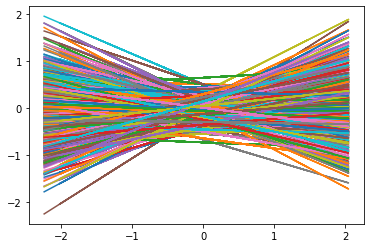

In [124]:
# Prior check
fig, ax = plt.subplots()

for i in range(len(hw1_prior_pred['area'])):
    ax.plot(fox_df.area_std, hw1_prior_pred['alpha'][i] + hw1_prior_pred['area'][i]*fox_df.area_std)

In [127]:
xseq = [-2, 2]
area_std_shrd.set_value(np.array(xseq))
avgfood_std_shrd.set_value(np.array(xseq))
groupsize_std_shrd.set_value(np.array(xseq))

with hw1:
    hw1_prior_sample = pm.sample_prior_predictive(var_names=['area', 'weight', 'alpha'])

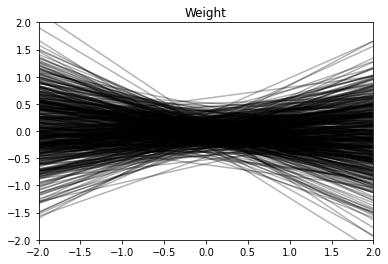

In [136]:
fig, ax = plt.subplots()

for i in range(len(hw1_prior_sample['area'])):
    ax.plot(xseq, hw1_prior_sample["alpha"][i] + hw1_prior_sample["area"][i]*np.array(xseq), c="black", alpha=0.3)
    
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title('Weight')
plt.show()

2. **Now infer the causal impact of adding food to a territory. Would this
make foxes heavier? Which covariates do you need to adjust for to estimate
the total causal influence of food?**

In [181]:
avgfood_std_shrd = shared(fox_df.avgfood_std.values)

with pm.Model() as hw2:
    avg_food = pm.Normal('avg_food', 0, .3)
    alpha = pm.Normal('alpha', 0, .2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + avg_food*avgfood_std_shrd)
    weight = pm.Normal('weight', mu, sigma, observed=fox_df.weight_std)
    hw2_prior_pred = pm.sample_prior_predictive(var_names=['avg_food', 'weight', 'alpha'])
    hw2_trace = pm.sample()
    hw2_posterior_sample = pm.sample_posterior_predictive(hw2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, avg_food]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [182]:
# Posterior influence
with hw2:
    display(az.summary(hw2_trace, hdi_prob=.89, skipna=True, kind='stats', var_names=['avg_food', 'alpha', 'sigma']).round(2))

,mean,sd,hdi_5.5%,hdi_94.5%
avg_food,-0.02,0.09,-0.16,0.13
alpha,0.00,0.08,-0.12,0.15
sigma,1.01,0.06,0.90,1.11


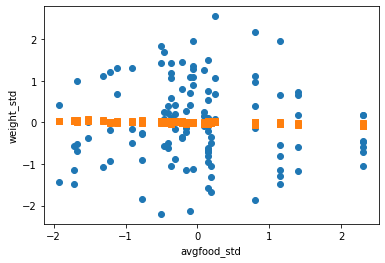

In [183]:
fig, ax = plt.subplots()

ax.plot(fox_df.avgfood_std, fox_df.weight_std, linestyle='None', marker='o')
ax.plot(fox_df.avgfood_std, hw2_posterior_sample['weight'].mean(0), marker='s', linestyle='None')
ax.set_xlabel('avgfood_std')
ax.set_ylabel('weight_std');

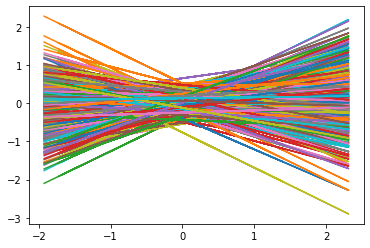

In [184]:
# Prior check
fig, ax = plt.subplots()

for i in range(len(hw2_prior_pred['avg_food'])):
    ax.plot(fox_df.avgfood_std, hw2_prior_pred['alpha'][i] + hw2_prior_pred['avg_food'][i]*fox_df.avgfood_std)

3. **Now infer the causal impact of group size. Which covariates do you need
to adjust for? Looking at the posterior distribution of the resulting model,
what do you think explains these data? That is, can**

In [187]:
avgfood_std_shrd = shared(fox_df.avgfood_std.values)
groupsize_std_shrd = shared(fox_df.groupsize_std.values)

with pm.Model() as hw3:
    avg_food = pm.Normal('avg_food', 0, .3)
    group_size = pm.Normal('group_size', 0, .3)
    alpha = pm.Normal('alpha', 0, .2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + avg_food*avgfood_std_shrd + group_size*groupsize_std_shrd)
    weight = pm.Normal('weight', mu, sigma, observed=fox_df.weight_std)
    hw3_prior_pred = pm.sample_prior_predictive(var_names=['avg_food', 'group_size', 'weight', 'alpha'])
    hw3_trace = pm.sample()
    hw3_posterior_sample = pm.sample_posterior_predictive(hw3_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, group_size, avg_food]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [188]:
# Posterior influence
with hw3:
    display(az.summary(hw3_trace, hdi_prob=.89, skipna=True, kind='stats', var_names=['avg_food', 'group_size', 'alpha', 'sigma']).round(2))

,mean,sd,hdi_5.5%,hdi_94.5%
avg_food,0.32,0.16,0.05,0.56
group_size,-0.41,0.16,-0.68,-0.18
alpha,-0.00,0.08,-0.12,0.14
sigma,0.97,0.07,0.86,1.07


/home/jonathan/.conda/envs/rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

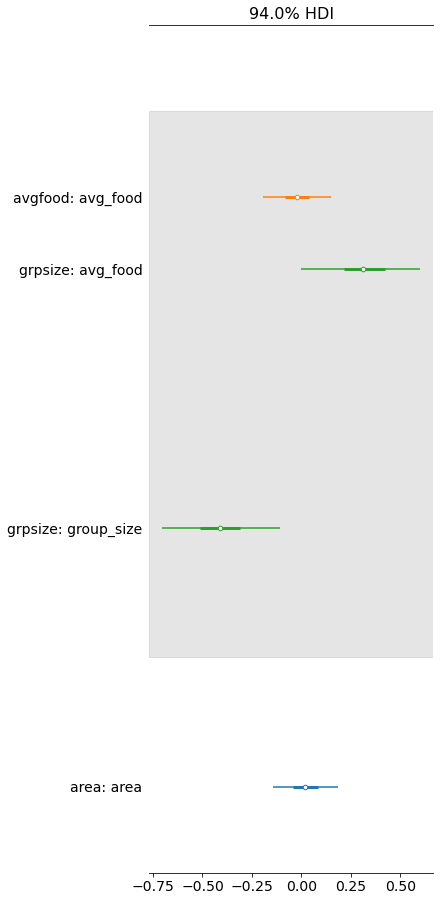

In [194]:
# with hw3:
az.plot_forest([hw1_trace, hw2_trace, hw3_trace], 
                model_names=['area', 'avgfood', 'grpsize'],
                var_names=['avg_food', 'group_size', 'area'],
                combined=True)